#### Objectius:
- Kmeans
- Clustering jeràrquic

Anem a practicar i a familiaritzar-nos amb algoritmes de clustering.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import normalize
from kneed import DataGenerator, KneeLocator
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
from scipy import stats
from scipy.stats import iqr
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder


from pandas_profiling import ProfileReport

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
df = pd.read_csv('DelayedFlights.csv')
df.head(5)

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,N726SW,101.0,115.0,87.0,11.0,25.0,IND,JAX,688,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


## Introducció

Donada la naturalesa explorativa dels algorismes no-supervisats, en aquesta tasca hem volgut jugar amb diversos models i els processos que impliquen escollir-ne un o altre. Hem fet K-Means amb PCA i sense, i fins i tot amb una sola variable (Arrival Delay), per veure com variaven els clusters segons les variables escollides i les seves transformacions. Més endavant hem vist els algorismes DBSCAN i Gaussian Mixture Model (GMM) i, per últim, com ens demana l'exercici 2, hem treballat amb algorismes jeràrquics. En cada model hem buscat el número idoni de clusters seguint diferents mètodes: SSE, Silhouette i dendograms.  

A banda, hem provat de treure algun sentit als clusters fent, a posteriori, un estudi estadístic de les variables numèriques i categòriques segons el cluster assignat a cada observació. L'estudi estadístic l'hem reservat a dos casos en concret: un per a K-Means fent servir el PCA amb 13 principal components, i un per l'algorisme jeràrquic fent PCA amb 2 principal components.  

Per acabar hem reunit els silhouettes scores dels diferents models en una taula per poder comparar les mètriques resultants més fàcilment.

### Nivell 1


#### - Exercici 1
Classifica els diferents vols utilitzant l'algorisme de K-means.





In [3]:
df_1 = df

Eliminem les 'Year' i 'TailNum', la primera per ser una constant i la segona perquè sense més investigació és fa inservible la seva transformació.


In [4]:
df_1.drop(['Unnamed: 0','Year', 'TailNum',], axis=1, inplace=True)

Fem LabelEncoder de les categòriques que ens queden:

In [5]:
org_encoder = LabelEncoder()

df_1['Origin']= org_encoder.fit_transform(df_1['Origin'])

df_1.head()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1,3,4,2003.0,1955,2211.0,2225,WN,335,128.0,150.0,116.0,-14.0,8.0,135,TPA,810,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,3,4,754.0,735,1002.0,1000,WN,3231,128.0,145.0,113.0,2.0,19.0,135,TPA,810,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,1,3,4,628.0,620,804.0,750,WN,448,96.0,90.0,76.0,14.0,8.0,140,BWI,515,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,1,3,4,1829.0,1755,1959.0,1925,WN,3920,90.0,90.0,77.0,34.0,34.0,140,BWI,515,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,1,3,4,1940.0,1915,2121.0,2110,WN,378,101.0,115.0,87.0,11.0,25.0,140,JAX,688,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [6]:
# Afegit a posteriori de l'estudi estadístic de les variables categòriques. Eliminem un valor per intentar que origen i 
# destí coincideixin.

df_1 = df_1[df_1['Dest'] != 'OGD']

In [7]:
dest_encoder = LabelEncoder()

df_1['Dest']= dest_encoder.fit_transform(df_1['Dest'])

df_1.head()

<ipython-input-7-5d3325e9aa88>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['Dest']= dest_encoder.fit_transform(df_1['Dest'])


,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1,3,4,2003.0,1955,2211.0,2225,WN,335,128.0,150.0,116.0,-14.0,8.0,135,285,810,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,3,4,754.0,735,1002.0,1000,WN,3231,128.0,145.0,113.0,2.0,19.0,135,285,810,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,1,3,4,628.0,620,804.0,750,WN,448,96.0,90.0,76.0,14.0,8.0,140,48,515,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,1,3,4,1829.0,1755,1959.0,1925,WN,3920,90.0,90.0,77.0,34.0,34.0,140,48,515,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,1,3,4,1940.0,1915,2121.0,2110,WN,378,101.0,115.0,87.0,11.0,25.0,140,150,688,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [8]:
uq_encoder = LabelEncoder()

df_1['UniqueCarrier']= uq_encoder.fit_transform(df_1['UniqueCarrier'])

df_1.head()


<ipython-input-8-8eba17926270>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['UniqueCarrier']= uq_encoder.fit_transform(df_1['UniqueCarrier'])


,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1,3,4,2003.0,1955,2211.0,2225,17,335,128.0,150.0,116.0,-14.0,8.0,135,285,810,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,3,4,754.0,735,1002.0,1000,17,3231,128.0,145.0,113.0,2.0,19.0,135,285,810,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,1,3,4,628.0,620,804.0,750,17,448,96.0,90.0,76.0,14.0,8.0,140,48,515,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,1,3,4,1829.0,1755,1959.0,1925,17,3920,90.0,90.0,77.0,34.0,34.0,140,48,515,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,1,3,4,1940.0,1915,2121.0,2110,17,378,101.0,115.0,87.0,11.0,25.0,140,150,688,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [9]:
cc_encoder = LabelEncoder()

df_1['CancellationCode']= cc_encoder.fit_transform(df_1['CancellationCode'])

df_1.head()

<ipython-input-9-610fbd27b9b5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['CancellationCode']= cc_encoder.fit_transform(df_1['CancellationCode'])


,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1,3,4,2003.0,1955,2211.0,2225,17,335,128.0,150.0,116.0,-14.0,8.0,135,285,810,4.0,8.0,0,3,0,NaN,NaN,NaN,NaN,NaN
1,1,3,4,754.0,735,1002.0,1000,17,3231,128.0,145.0,113.0,2.0,19.0,135,285,810,5.0,10.0,0,3,0,NaN,NaN,NaN,NaN,NaN
2,1,3,4,628.0,620,804.0,750,17,448,96.0,90.0,76.0,14.0,8.0,140,48,515,3.0,17.0,0,3,0,NaN,NaN,NaN,NaN,NaN
3,1,3,4,1829.0,1755,1959.0,1925,17,3920,90.0,90.0,77.0,34.0,34.0,140,48,515,3.0,10.0,0,3,0,2.0,0.0,0.0,0.0,32.0
4,1,3,4,1940.0,1915,2121.0,2110,17,378,101.0,115.0,87.0,11.0,25.0,140,150,688,4.0,10.0,0,3,0,NaN,NaN,NaN,NaN,NaN


Imputem:

In [10]:
for i in df_1.columns:
    df_1[i].fillna(df_1[i].median(), inplace = True)

C:\Users\ab\anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


#### Tractament d'outliers

Fem tractament d'outliers per intentar reduir la variabilitat i fer més efectiva la PCA i la delimitació de clusters:

In [11]:
df_1.shape

(1936757, 27)

In [12]:
Q1 = df_1.quantile(0.25)
Q3 = df_1.quantile(0.75)
IQR = Q3 - Q1

In [13]:
df_2 = df_1[~((df_1 < (Q1 - 1.5 * IQR)) |(df_1 > (Q3 + 1.5 * IQR))).any(axis=1)]
print(df_2.shape)

(1006080, 27)


In [14]:
df_2.skew()

Month                0.206215
DayofMonth          -0.014308
DayOfWeek           -0.005501
DepTime             -0.157438
CRSDepTime          -0.148593
ArrTime             -0.263324
CRSArrTime          -0.258442
UniqueCarrier       -0.623052
FlightNum            0.970505
ActualElapsedTime    0.845849
CRSElapsedTime       0.825569
AirTime              0.888029
ArrDelay             0.504609
DepDelay             1.363378
Origin              -0.039947
Dest                -0.101402
Distance             0.932129
TaxiIn               0.959406
TaxiOut              1.071092
Cancelled            0.000000
CancellationCode     0.000000
Diverted             0.000000
CarrierDelay         2.129909
WeatherDelay         0.000000
NASDelay             2.614121
SecurityDelay        0.000000
LateAircraftDelay    1.693730
dtype: float64

In [15]:
z = np.abs(stats.zscore(df_2))
print(z)

[[1.47937832 1.45863257 0.00858712 ... 0.12431132        nan 0.33368174]
 [1.47937832 1.45863257 0.00858712 ... 0.12431132        nan 0.33368174]
 [1.47937832 1.45863257 0.00858712 ... 0.12431132        nan 0.33368174]
 ...
 [1.6996034  0.31456805 1.01280973 ... 0.85819586        nan 1.15209364]
 [1.6996034  0.31456805 1.01280973 ... 0.12431132        nan 0.33368174]
 [1.6996034  0.31456805 1.01280973 ... 0.12431132        nan 0.33368174]]


C:\Users\ab\anaconda3\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [16]:
outliers = np.where(z>3)

In [17]:
df_out = pd.DataFrame(data = outliers)

#### Hopkins Statistics

To understand if the dataset can be clustered, we used the Hopkins statistic, which tests the spatial randomness of the data and indicates the cluster tendency or how well the data can be clustered. It calculates the probability that a given data is generated by a uniform distribution (Alboukadel Kassambara, n.d.). The inference is as follows for a data of dimensions ‘d’:

- If the value is around 0.5 or lesser, the data is uniformly distributed and hence it is unlikely to have statistically significant clusters.  

- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster and therefore likely to have statistically significant clusters.

--------

Aquest fragment l'he agafat del següent kaggle ( https://www.kaggle.com/rohanadagouda/unsupervised-learning-using-k-prototype-and-dbscan) i m'ha semblat interessant afegir-lo, a un nivell intuitiu i inicial pe provar les dades.

In [18]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan

def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [19]:
# Agafem un mostra pel cost computacional:
df_sample = df_2.sample(20000, random_state=1)

In [20]:
df_sample.reset_index(drop=True, inplace = True)

Segons els resultats fent Hopkins statistics les nostres dades poden tenir agrupacions amb significança estadística.

In [21]:
hopkins(df_sample)

0.9073378863055332

Finalment creem la mitjana de vols per companyia de la mostra abans de transformar les dades per poder comparar els clusters més endavant.

## 1. K-Means amb  PCA explained_variance_ratio = 0.95

###  PCA

In [22]:
std_sample = StandardScaler().fit_transform(df_sample)

Escollim el número de Principal Components en relació a la explained variance:

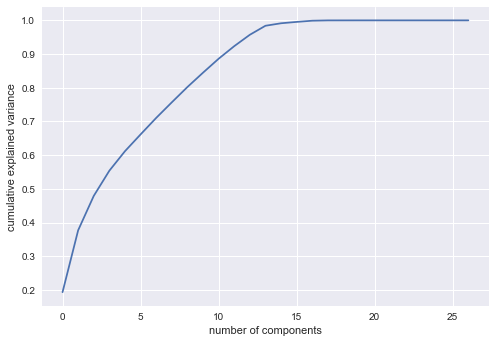

In [23]:
plt.style.use('seaborn')
pca = PCA(random_state=42).fit(std_sample)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Agafem 13 components principals per reduir les dimensions de la mostra i mantenir el màxim d'explained variance ratio, abans de fer el K-means.

In [24]:
pca = PCA(n_components=13, random_state=42)
sample_pca = pca.fit_transform(std_sample)
print(pca.explained_variance_ratio_) # Treiem els variance ratio del número de components seleccionats
print(pca.explained_variance_ratio_.sum()) # Sumem el variance ratio per veure quanta informació treiem amb el número de PCA

[0.1934677  0.18356338 0.10209635 0.07479532 0.05785486 0.04978794
 0.04899029 0.04620784 0.04541113 0.0425744  0.04135679 0.03734733
 0.03380472]
0.9572580442359235


Passem els PC en format array a DataFrame:

In [25]:
df_pca  = pd.DataFrame(data = sample_pca
             , columns = ['PC 1', 'PC 2','PC 3', 'PC 4',
                          'PC 5', 'PC 6','PC 7', 'PC 8',
                          'PC 9', 'PC 10','PC 11', 'PC 12',
                          'PC 13'
                        ])

df_pca

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13
0,1.052767,4.010653,0.266503,-0.952623,0.108611,0.469240,-0.990163,0.953268,1.600509,0.625389,-0.970357,0.392180,-0.783636
1,2.184518,-0.323261,-0.090517,1.874891,2.056165,0.297278,-0.449282,1.337892,-0.752407,0.903734,-1.280113,-1.122349,-1.561087
2,-0.612209,-3.519242,0.723678,-0.283913,-0.294114,0.828486,0.417154,-2.737321,-0.455074,-0.021251,-0.770843,0.088774,-0.009167
3,1.122958,-1.404897,-2.416182,-1.451783,0.451265,-0.017607,-0.781564,0.548403,-0.902535,0.693886,-0.458973,-0.162815,0.883843
4,1.605827,0.450161,-1.226797,-0.983235,-0.185080,-0.493447,-0.750073,-0.034845,-0.475971,-0.001431,-0.819752,-0.079170,0.134778
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-0.219930,-0.349242,0.664179,2.132274,2.061073,-1.886340,1.076521,1.976193,1.231610,-0.726090,1.545885,-0.014984,-1.451854
19996,-0.360238,-2.035086,-1.858556,-0.049943,0.480539,1.321913,0.264002,-0.360216,0.172388,0.339487,-1.194875,-2.006891,-1.568021
19997,3.344213,1.566880,0.144060,-0.683515,-0.690562,0.656016,1.736257,-0.128744,1.617580,0.161638,0.245489,-0.965079,-0.525101
19998,1.140280,-1.311012,-2.192920,-0.940912,-0.780599,-0.262171,0.747219,1.466682,-0.636985,-0.737781,-0.072025,-0.425527,1.265273


### Mètriques

Busquem el número adhient de clusters: elbow method

In [26]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_pca)
    sse.append(kmeans.inertia_)

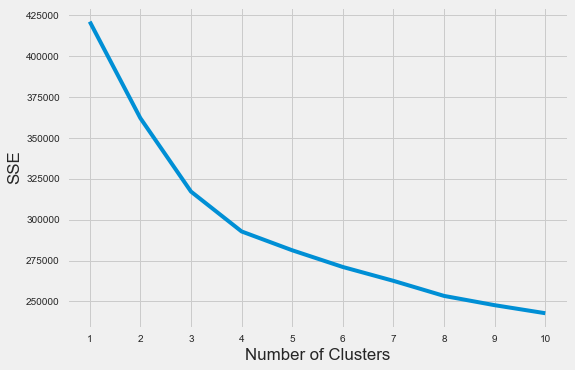

In [27]:
 plt.style.use("fivethirtyeight")
 plt.plot(range(1, 11), sse)
 plt.xticks(range(1, 11))
 plt.xlabel("Number of Clusters")
 plt.ylabel("SSE")
 plt.show()

In [28]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

4

Segons silhouette coefficient en comptes de SSE:

In [29]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(sample_pca)
    score = metrics.silhouette_score(sample_pca, kmeans.labels_, sample_size = 1000)
    silhouette_coefficients.append(score)

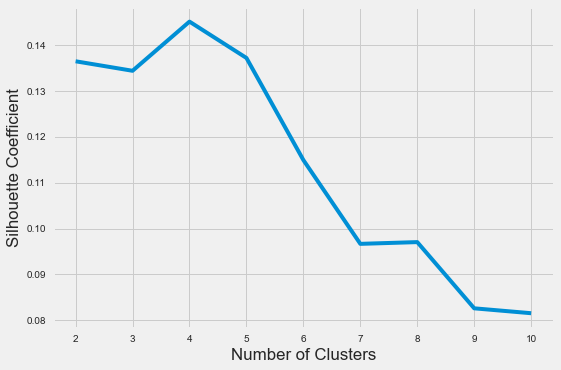

In [30]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

### Agrupació

Volem 4 clusters, ja que és el número amb el qual obtenim el millor silhouette coefficient tenint en compte l'elbow_method:

In [31]:
kmeans = KMeans(init="random",
       n_clusters=4,
       n_init=10,
     max_iter=300, 
    random_state= 0)

In [32]:
kmeans.fit(sample_pca)

KMeans(init='random', n_clusters=4, random_state=0)

In [33]:
# The lowest SSE value
kmeans.inertia_

292784.4294330888

In [34]:
# Final locations of the centroid
kmeans.cluster_centers_

array([[-1.16111574e+00, -1.59453443e+00,  2.64923229e+00,
        -4.95280846e-01, -4.39861107e-01,  1.85532467e-01,
        -1.96678073e-01, -7.67213321e-02, -6.94112954e-02,
         1.61457526e-02, -3.52145997e-03,  1.31317034e-02,
        -2.32025863e-02],
       [-1.11862006e+00, -1.16707587e+00, -9.86388239e-01,
         2.27010439e-01,  1.10065671e-01, -5.44525717e-02,
         6.51605908e-02,  2.85578955e-02,  2.19740476e-02,
         4.60949111e-03,  4.29220371e-04,  1.71459566e-02,
         1.32471740e-02],
       [ 2.99242223e+00, -5.09961504e-01, -1.47659975e-01,
        -9.93045794e-02,  4.54342157e-02, -1.11329031e-02,
         6.65560908e-03, -1.37454708e-03,  2.04858396e-02,
         9.79647399e-03,  2.17857480e-02, -4.81127446e-02,
        -1.35081343e-02],
       [-4.48194526e-01,  2.23241849e+00,  9.68304423e-03,
         4.28844303e-02,  3.92715271e-02, -1.38837545e-02,
         1.06299819e-02,  3.67794818e-03, -7.87128814e-03,
        -1.83946432e-02, -1.41943679e

In [35]:
# The number of iterations required to converge
kmeans.n_iter_

11

In [36]:
labels = kmeans.labels_

In [37]:
labels

array([3, 2, 0, ..., 2, 1, 3])

Fem un scatter plot dels dos primers PC, distingim la distribució dels clusters per colors i els seus centres amb creus:

In [38]:
centroids = kmeans.cluster_centers_

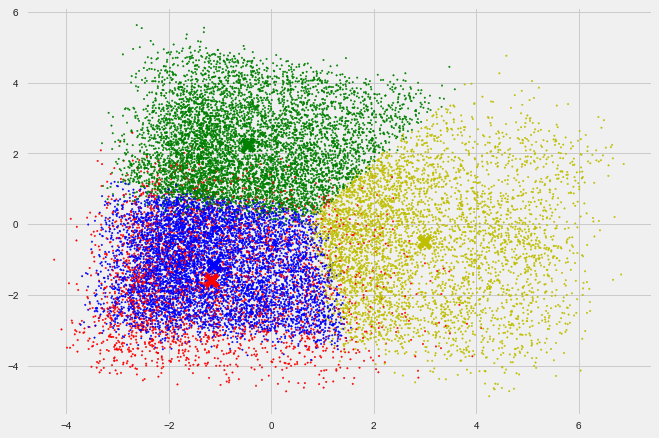

In [39]:
colors = ['r','b','y','g','c','m']
plt.figure(figsize=(10, 7))  
plt.scatter(df_pca['PC 1'], df_pca['PC 2'], color=[colors[l_] for l_ in labels], label=labels, s=2) 
plt.scatter(centroids[:, 0],centroids[:, 1], color=[c for c in colors[:len(centroids)]], marker = "x", s=150, linewidths = 5, zorder = 10)

In [40]:
slh_13pc = metrics.silhouette_score(sample_pca, labels, metric = 'euclidean', sample_size = 4000)
slh_13pc

0.13809454425665632

In [41]:
metrics.calinski_harabasz_score(sample_pca, labels)

2923.2771982608215

### Estudi estadístic dels clusters en el df original

Una vegada tens els clusters pots fer estadístiques de quines variables tens. Amb les variables numèriques la mitja, desviació típica, etc. i amb les variables categòriques quantes variables tens de cada grup.  

Això et descriu com són els individus de cada cluster de manera interpretable encara que hagis fet el PCA.

In [42]:
labels = pd.Series(labels)

In [43]:
df_sample['Labels'] = labels

In [44]:
df_sample['Labels'].value_counts()

1    6553
3    6345
2    4437
0    2665
Name: Labels, dtype: int64

#### Número d'observacions assignades a cada cluster:

- Cluster 0:    2665
- Cluster 1:    6553
- Cluster 2:    4437
- Cluster 3:    6345

Creem un groupby per clusters

In [45]:
label_grp = df_sample.groupby(['Labels'])

Separem les variables categòriques,

In [46]:
categoriques = ['UniqueCarrier', 'Origin', 'Dest', 'CancellationCode']

i eliminem, a banda de les categòriques, les columnes numèriques que no ens serveixen per l'anàlisis estadístic de les variables numèriques:

In [47]:
numeriques = df_sample.drop(['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest', 'CancellationCode',
                             'Labels', 'SecurityDelay', 'WeatherDelay', 'Diverted', 'Cancelled'],1).columns

### 1.1 Estudi estadístic dels clusters per variables numèriques i categòriques:

#### Categòriques: Unique Carrier

Estudiem com queden dividits els vols de les companyies en la divisió per clusters amb K-Means i PCA:

In [48]:
len(df['UniqueCarrier'].unique())

20

In [49]:
for i in range (0,4):
    x = len(label_grp.get_group(i)['UniqueCarrier'].unique())
    print(x)

20
20
18
20


Només el Cluster 1 no té observacions de totes les companyies. Mirem els valors concrets. Passem una funció per mapejar els valors del LabelEncoder:

In [50]:
def get_integer_mapping(le):
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res

integerMapping = get_integer_mapping(uq_encoder)

Afegim les dues companyies(2 i 10) de les quals no en tenim cap observació pel Cluster 2, per poder mapejar-les a la visualització:

In [51]:
falta = pd.Series([0, 0], index=[2, 10])
x = label_grp.get_group(2)['UniqueCarrier'].value_counts()
x = x.append(falta)

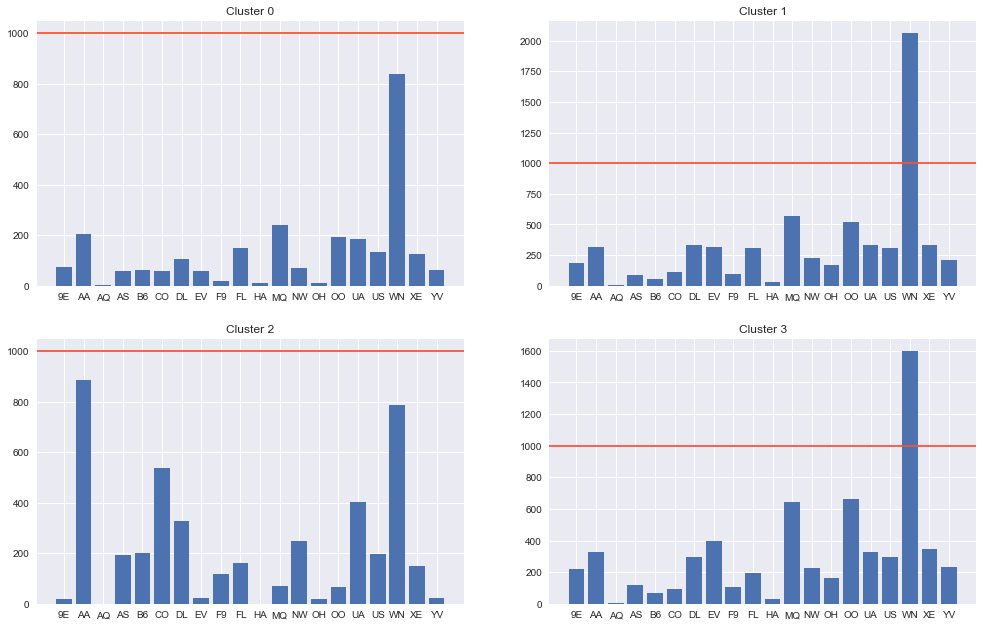

In [52]:
plt.style.use('seaborn')

fig, axes = plt.subplots(2,2, figsize=(15, 10))
    
index = integerMapping.keys()
values = label_grp.get_group(0)['UniqueCarrier'].value_counts().sort_index()
axes[0,0].bar(index, values)
axes[0,0].set_xticks(range(0, 20))
axes[0,0].set_title('Cluster 0')
axes[0,0].axhline(1000, color ='#fc4f30', label='Avg. Number of Flights by Carrier')

index = integerMapping.keys()
values = label_grp.get_group(1)['UniqueCarrier'].value_counts().sort_index()
axes[0,1].bar(index, values)
axes[0,1].set_xticks(range(0, 20))
axes[0,1].set_title('Cluster 1')
axes[0,1].axhline(1000, color ='#fc4f30', label='Avg. Number of Flights by Carrier')

index = integerMapping.keys()
values = x.sort_index()
axes[1,0].bar(index, values)
axes[1,0].set_xticks(range(0, 20))
axes[1,0].set_title('Cluster 2')
axes[1,0].axhline(1000, color ='#fc4f30', label='Avg. Number of Flights by Carrier')

index = integerMapping.keys()
values = label_grp.get_group(3)['UniqueCarrier'].value_counts().sort_index() #adaptar els indexs a la llargada dels valors, abans en faltaven 2
axes[1,1].bar(index, values)
axes[1,1].set_xticks(range(0, 20))
axes[1,1].set_title('Cluster 3')
axes[1,1].axhline(1000, color ='#fc4f30', label='Avg. Number of Flights by Carrier')


plt.show()

Conclusions: sembla que tots els clusters menys el Cluster 2 tenen una distribució més o menys proporcional dels vols per companyia a les mostres agrupades en ells. En el Cluster 2, a diferència dels altres, veiem una gran presència (un peak) de vols en el Carrier 'AA'. Els carriers 'CO' i 'DL' també tenen més presència proporcional en aquest cluster que en la resta. En canvi disminueixen els vols de 'WN' i 'OO'.

#### Categòriques: Cancellation Code

In [53]:
df['CancellationCode'].value_counts()

N    1936125
B        307
A        246
C         80
Name: CancellationCode, dtype: int64

In [54]:
for i in range (0,4):
    x = len(label_grp.get_group(i)['CancellationCode'].unique())
    print(x)

1
1
1
1


In [55]:
cc = []
for i in cc_encoder.classes_:
    cc.append(i)

In [56]:
cc

['A', 'B', 'C', 'N']

In [57]:
df_sample['CancellationCode'].value_counts()

3    20000
Name: CancellationCode, dtype: int64

Totes les observacions de la mostra pertanyen a un únic valor del codi de cancel·lació: (3, no-cancel·lats).

#### Categòriques: Origen i Destí

In [58]:
len(df_1['Origin'].unique())

303

Fem el mateix amb Dest. Veiem que la llargada dels valors dels aeroports de destí es diferent dels d'arribada, hi ha un aeroport més. (Aquí no es veu perquè ja hem eliminat un valor categòric de 'Dest' al principi perquè quadrin)

In [59]:
len(df_1['Dest'].unique())

303

Comparem els valors únics de les variables Origen i Destí per veure si coincideixen tots els aeroports, ja que la quantitat de valors hem fet que sigui la mateixa:

In [60]:
org = []
for i in org_encoder.classes_:
    org.append(i)

In [61]:
dest = []
for i in dest_encoder.classes_:
    dest.append(i)

In [62]:
bool_list_dest = list(map(lambda x, y: x == y, org, dest))

Veiem que les dues llistes d'areoports d'origen i d'arribada són iguals en un principi fins que deixen de coincidir, probablement perquè s'afegeix l'aeroport diferent.

In [63]:
bool_list_dest

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 Fa

In [64]:
mask_dest = bool_list_dest
dest_arr = dest_encoder.classes_

In [65]:
dest_dif = dest_arr[np.logical_not(mask_dest)].tolist()

In [66]:
bool_list_org = list(map(lambda x, y: x == y, dest, org))

In [67]:
mask_org = bool_list_org
org_arr = org_encoder.classes_

In [68]:
org_dif = org_arr[np.logical_not(mask_org)].tolist()

In [69]:
org_dif.sort()
dest_dif.sort()

In [70]:
bool_list_org = list(map(lambda x, y: x == y, dest_dif, org_dif))

In [71]:
mask_final = bool_list_dest
org_final = org_encoder.classes_

In [72]:
dif_final = np.ma.masked_array(org_final, np.logical_not(mask_final))

In [73]:
dif_final

masked_array(data=['ABE', 'ABI', 'ABQ', 'ABY', 'ACK', 'ACT', 'ACV', 'ACY',
                   'ADK', 'ADQ', 'AEX', 'AGS', 'AKN', 'ALB', 'ALO', 'AMA',
                   'ANC', 'ASE', 'ATL', 'ATW', 'AUS', 'AVL', 'AVP', 'AZO',
                   'BDL', 'BET', 'BFL', 'BGM', 'BGR', 'BHM', 'BIL', 'BIS',
                   'BJI', 'BLI', 'BMI', 'BNA', 'BOI', 'BOS', 'BPT', 'BQK',
                   'BQN', 'BRO', 'BRW', 'BTM', 'BTR', 'BTV', 'BUF', 'BUR',
                   'BWI', 'BZN', 'CAE', 'CAK', 'CDC', 'CDV', 'CEC', 'CHA',
                   'CHO', 'CHS', 'CIC', 'CID', 'CLD', 'CLE', 'CLL', 'CLT',
                   'CMH', 'CMI', 'CMX', 'COD', 'COS', 'CPR', 'CRP', 'CRW',
                   'CSG', 'CVG', 'CWA', --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, -

Hem intentat comparar les dues llistes per veure si es tractava només d'un afegit i si a l'eliminar-lo (hem buscat on deixavem de conicidir i hem eliminat el valor abans del label encoder, al principi de la tasca), coincidirien els aeroports d'origen i d'arribada, però hem vist que no era el cas. La mida és gairebé idèntica però el contingut no, i al tenir tants valors únics l'anàlisi és fa molt complicat. Hem decidit agafar només aquells aeroports que suposin, com a mínim, un 2% del tràfic aeri total de la mostra. Primer agafem els del df original i després els de la mostra començant pels d'origen:

Recuperem els valors categòrics del LabelEncoder dels aeroports amb un mapping:

In [74]:
def get_integer_mapping(le):
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res

integerMapping = get_integer_mapping(org_encoder)

Invertim els valors del diccionari perquè els keys siguin els valors numèrics i els values els categòrics:

In [75]:
inv_map = {v: k for k, v in integerMapping.items()}

In [76]:
df['Origin'].value_counts()[df['Origin'].value_counts(normalize =True, ascending=False) > 0.02]

18     131613
210    125979
81      95414
80      74323
157     58772
136     56847
220     55720
155     53710
96      52925
87      43923
259     43801
Name: Origin, dtype: int64

In [77]:
x = df_sample['Origin'].value_counts(normalize =True, ascending=False)

In [78]:
x[x > 0.02]

18     0.07060
210    0.05920
81     0.05340
80     0.04210
220    0.03245
136    0.02975
155    0.02860
157    0.02650
177    0.02135
87     0.02025
Name: Origin, dtype: float64

In [79]:
org_values =  pd.DataFrame(data = x.index)
org_values[0] = org_values[0].map(inv_map)
org_values['values'] = x.values
org_values.columns = ['Origin', ' Flights']
org_values

,Origin,Flights
0,ATL,0.07060
1,ORD,0.05920
2,DFW,0.05340
3,DEN,0.04210
4,PHX,0.03245
5,IAH,0.02975
6,LAS,0.02860
7,LAX,0.02650
8,MCO,0.02135
9,DTW,0.02025


Passem els labelencoders dels aeroports d'origen majoritaris a un DataFrame i amb el map invertit en recuprem els valors categòrics:

In [80]:
for i in range (0,4):
    x = label_grp.get_group(i)['Origin'].value_counts(normalize =True, ascending=False)
    y = label_grp.get_group(i)['Origin'].value_counts(ascending=False)[x > 0.02]
    org_values =  pd.DataFrame(data = y.index)
    org_values[0] = org_values[0].map(inv_map)
    org_values['values'] = y.values
    org_values.columns = ['Origin', ' Flights']
    print(org_values)
   
    

   Origin   Flights
0     ORD       178
1     ATL       151
2     DFW        91
3     DEN        81
4     SFO        73
5     LAS        68
6     EWR        67
7     LAX        64
8     MCO        62
9     LGA        55
10    PHX        55
11    SAN        54
   Origin   Flights
0     ATL       622
1     ORD       394
2     DFW       305
3     DEN       280
4     PHX       206
5     IAH       181
6     LAS       176
7     LAX       162
8     DTW       161
9     BWI       143
10    DAL       137
11    MDW       134
12    CLT       134
   Origin   Flights
0     DFW       348
1     ORD       261
2     IAH       248
3     DEN       233
4     PHX       181
5     SEA       173
6     ATL       171
7     LAS       162
8     LAX       160
9     MCO       156
10    EWR       132
11    MSP       117
12    MIA       116
13    MDW       114
14    LGA        98
15    FLL        90
  Origin   Flights
0    ATL       468
1    ORD       351
2    DFW       324
3    DEN       248
4    PHX       207
5    L

Conclusions: És difícil treure conclusions d'aquestes variables. Tenim molts valors categòrics diferents i en cada cluster n'apareixen uns o altres. Tot i així hem aconseguit recuperar els valors categòrics després del label encoder, i podem veure quins aeroports d'origen i de destí són els majoritaris (més d'un 2% del tràfic total de la mostra) en cada cluster i quantes instàncies tenen assignades.

En el cas dels aeroports d'origen veiem que es repeteixen ATL (Atlanta), ONT (Ontario), DEN (Denver) i DCA (Washington Ronald Reagan) en les quatre primeres posicions en tots els clusters menys el Cluster 2. En el cluster 2 els aeroports majoritaris són DEN, ONT, IAD (Washington - Dulles) i PHL (Philadelphia). Igual que en l'anàlisi dels Carriers, el Cluster 2 és el més peculiar en el seu repartiment de valors categòrics respecte els altres.

Fem el mateix amb els de destí:

In [81]:
def get_integer_mapping(le):
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res

integerMapping = get_integer_mapping(dest_encoder)

In [82]:
inv_map = {v: k for k, v in integerMapping.items()}

In [83]:
df['Dest'].value_counts()[df['Dest'].value_counts(normalize =True, ascending=False) > 0.02]

ORD    108984
ATL    106898
DFW     70657
DEN     63003
LAX     59969
EWR     55861
LAS     48858
PHX     47836
SFO     46876
IAH     43905
Name: Dest, dtype: int64

In [84]:
x = df_sample['Dest'].value_counts(normalize =True, ascending=False)

x = x[x > 0.02]
x

18     0.05090
211    0.04185
81     0.03780
82     0.03565
156    0.02800
158    0.02740
221    0.02605
137    0.02165
Name: Dest, dtype: float64

In [85]:
dest_values =  pd.DataFrame(data = x.index)
dest_values[0] = dest_values[0].map(inv_map)
dest_values['values'] = x.values
dest_values.columns = ['Dest', ' Flights']
dest_values

,Dest,Flights
0,ATL,0.05090
1,ORD,0.04185
2,DEN,0.03780
3,DFW,0.03565
4,LAS,0.02800
5,LAX,0.02740
6,PHX,0.02605
7,IAH,0.02165


In [86]:
for i in range (0,4):
    x = label_grp.get_group(i)['Dest'].value_counts(normalize =True, ascending=False)
    y = label_grp.get_group(i)['Dest'].value_counts(ascending=False)[x > 0.02]
    dest_values =  pd.DataFrame(data = y.index)
    dest_values[0] = dest_values[0].map(inv_map)
    dest_values['values'] = y.values
    dest_values.columns = ['Dest', ' Flights']
    print(dest_values)

   

  Dest   Flights
0  ATL       139
1  ORD       134
2  DFW       109
3  DEN       107
4  LAS        75
5  PHX        68
6  LAX        62
7  DTW        55
  Dest   Flights
0  ATL       308
1  DEN       193
2  ORD       181
3  BWI       153
4  LAX       152
5  LAS       143
   Dest   Flights
0   DFW       264
1   ORD       224
2   IAH       217
3   DEN       215
4   SEA       192
5   LAS       181
6   LAX       178
7   PHX       171
8   ATL       158
9   MCO       132
10  EWR       119
11  MSP       112
12  FLL       110
13  MIA       104
14  MDW       101
15  LGA        91
16  BOS        90
  Dest   Flights
0  ATL       413
1  ORD       298
2  DEN       241
3  DFW       209
4  LAS       161
5  LAX       156
6  PHX       153
7  SLC       144
8  DTW       135


Conclusions: en el cas dels aeroports de destí tenim també ATL en les primeres posicions en tots els clusters a excepció del Cluster 2. En el cas dels aeroports de destí els clusters tenen menys aeroports. A excepció del Cluster 2 amb 17 aeroports diferents, els altres en tenen menys de 9. En el cluster 2 l'aeroport de destí més concorregut és DFW (Dallas/Fort Worth) seguit de ORD (Chicago O'Hare) i IAH (Houston George Bush).

#### Numèriques

In [87]:
numeriques

Index(['DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'FlightNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'CarrierDelay', 'NASDelay', 'LateAircraftDelay'], dtype='object')

Fem una taula amb les mitjanes i desviacions típiques de cada variable numèrica segons el seu cluster:

In [88]:
cl0_mean = label_grp[numeriques].get_group(0).mean()
cl0_std = label_grp[numeriques].get_group(0).std()

In [89]:
cl1_mean = label_grp[numeriques].get_group(1).mean()
cl1_std = label_grp[numeriques].get_group(1).std()

In [90]:
cl2_mean = label_grp[numeriques].get_group(2).mean()
cl2_std = label_grp[numeriques].get_group(2).std()

In [91]:
cl3_mean = label_grp[numeriques].get_group(3).mean()
cl3_std = label_grp[numeriques].get_group(3).std()

In [92]:
df_numeric = pd.DataFrame()

In [93]:
df_numeric['Variables'] = cl0_mean.index

In [94]:
df_numeric['Mean 0'] =cl0_mean.values
df_numeric['Mean 1'] =cl1_mean.values
df_numeric['Mean 2'] =cl2_mean.values
df_numeric['Mean 3'] =cl3_mean.values

In [95]:
df_numeric['Std 0'] =cl0_std.values
df_numeric['Std 1'] =cl1_std.values
df_numeric['Std 2'] =cl2_std.values
df_numeric['Std 3'] =cl3_std.values

In [96]:
df_numeric

,Variables,Mean 0,Mean 1,Mean 2,Mean 3,Std 0,Std 1,Std 2,Std 3
0,DepTime,1687.335084,1811.739509,1440.677710,1071.079117,313.483160,213.312380,358.062827,236.395735
1,CRSDepTime,1620.707317,1786.091561,1414.473518,1048.348306,313.850891,212.038090,356.139115,235.501859
2,ArrTime,1853.793996,1963.774302,1732.905792,1229.386131,312.105924,218.683177,349.078914,235.108445
3,CRSArrTime,1796.041651,1948.900351,1719.141086,1213.212608,313.451414,217.893302,348.064121,235.284104
4,FlightNum,2118.063039,2332.466351,1229.460897,2538.185973,1837.209264,1891.810078,1146.735976,1982.821044
5,ActualElapsedTime,99.967355,89.184190,189.244084,93.890938,37.891946,28.727921,36.820228,31.133561
6,CRSElapsedTime,104.985366,95.190905,197.293216,98.689362,39.482607,30.175727,37.336906,32.046282
7,AirTime,80.568105,70.308561,167.490647,74.411032,36.414674,27.641180,36.500982,30.113604
8,ArrDelay,35.178236,9.398596,8.526933,9.907171,9.055641,9.472543,12.929789,9.936497
9,DepDelay,40.196248,15.405311,16.576065,14.705595,10.319708,7.541132,9.975551,7.682111


Conclusions: 
- A primer cop d'ull podem observar com el Cluster 0 té una mitja molt superior als altres clusters en quant a Arrival Delay i Dep Delay (35 i 40 minuts respectivament) mentre que la resta ronden els (9 i 15 minuts respectivament).  


- També observem un salt quantitatiu en la mitja de la variable Distance en el Cluster 2 (1273 milles) mentre que la resta ronda les 500.  Això és veu reflexat de la mateixa manera en la variable 'AirTime', 'ActualElapsedTime' i 'CRSElapsedTime'.
 
 
- La variable LateAircraftDelay és molt superior en el cluster 0 (30min.) a la resta, que ronden els 8min.  

## 2. K-Means amb 2 PC per augmentar el silhouette score

In [97]:
df_sample = df_2.sample(20000, random_state=1)

In [98]:
df_sample.reset_index(drop=True, inplace = True)

In [99]:
std_sample = StandardScaler().fit_transform(df_sample)

In [100]:
# Agafem 2 components principals

pca = PCA(n_components=2, random_state=42)
sample_pca = pca.fit_transform(std_sample)
print(pca.explained_variance_ratio_) # Treiem els variance ratio del número de components seleccionats
print(pca.explained_variance_ratio_.sum()) # Sumem el variance ratio per veure quanta informació treiem amb el número de PCA

[0.1934677  0.18356338]
0.3770310725995811


In [101]:
df_pca  = pd.DataFrame(data = sample_pca
             , columns = ['PC 1', 'PC 2',
                        ])

df_pca

,PC 1,PC 2
0,1.052770,4.010667
1,2.184519,-0.323258
2,-0.612208,-3.519240
3,1.122956,-1.404912
4,1.605826,0.450159
...,...,...
19995,-0.219928,-0.349223
19996,-0.360239,-2.035090
19997,3.344212,1.566877
19998,1.140278,-1.311031


Busquem el millor número de clusters pels nous components: elbow method i SSE

In [102]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_pca)
    sse.append(kmeans.inertia_)

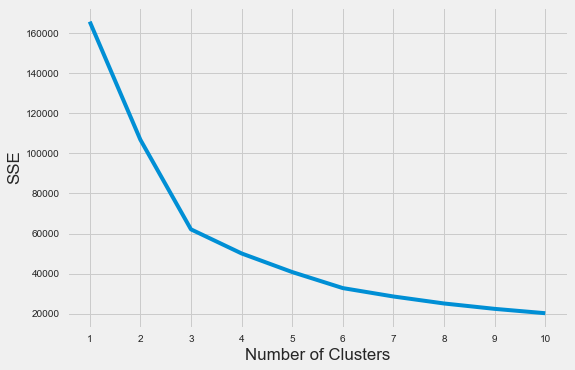

In [103]:
 plt.style.use("fivethirtyeight")
 plt.plot(range(1, 11), sse)
 plt.xticks(range(1, 11))
 plt.xlabel("Number of Clusters")
 plt.ylabel("SSE")
 plt.show()

In [104]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

3

Segons silhouette coefficient en comptes de SSE:

In [105]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(sample_pca)
    score = metrics.silhouette_score(sample_pca, kmeans.labels_, sample_size = 1000)
    silhouette_coefficients.append(score)

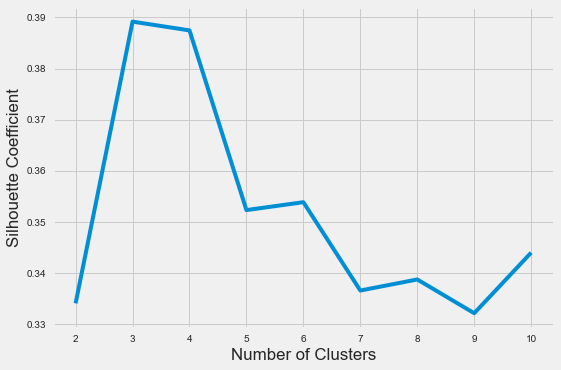

In [106]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

### Agrupació

In [107]:
# Volem 3 clusters, ja que és el mètode amb el qual obtenim el millor silhouette coefficient i conicideix amb l'elbow_method:

kmeans = KMeans(init="random",
       n_clusters=3,
       n_init=10,
     max_iter=300,
               random_state= 0)

In [108]:
kmeans.fit(sample_pca)

KMeans(init='random', n_clusters=3, random_state=0)

In [109]:
# The lowest SSE value
kmeans.inertia_

62081.63977553007

In [110]:
# Final locations of the centroid
kmeans.cluster_centers_

array([[-1.29808248, -1.44832969],
       [ 2.81254535, -0.59834818],
       [-0.51416873,  2.08543741]])

In [111]:
# The number of iterations required to converge
kmeans.n_iter_

8

In [112]:
labels = kmeans.labels_

In [113]:
labels

array([2, 1, 0, ..., 1, 1, 2])

### Visualització dels clusters

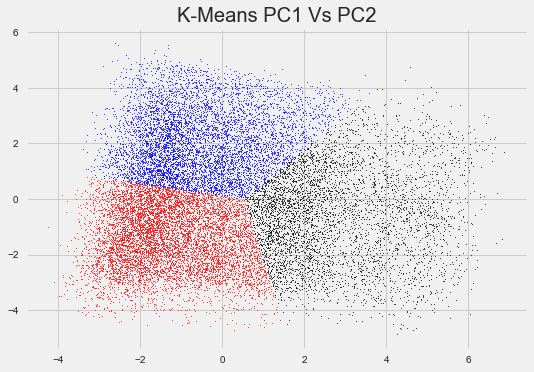

In [114]:
plt.scatter(sample_pca[labels ==0,0], sample_pca[labels == 0,1], s=0.2, c='red')
plt.scatter(sample_pca[labels ==1,0], sample_pca[labels == 1,1], s=0.2, c='black')
plt.scatter(sample_pca[labels ==2,0], sample_pca[labels == 2,1], s=0.2, c='blue')
plt.title('K-Means PC1 Vs PC2')
plt.show()

In [115]:
slh_2pc = metrics.silhouette_score(sample_pca, labels, metric = 'euclidean', sample_size = 4000)
slh_2pc

0.39472109024509816

In [116]:
metrics.calinski_harabasz_score(sample_pca, labels)

16719.498043877575

### 2.1 DBSCAN

Fem el DBSCAN per defecte (sense canviar paràmetres) amb les dades anteriors

In [117]:
clustering = DBSCAN().fit(sample_pca)
y_dbs = clustering.labels_

In [118]:
y_dbs

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

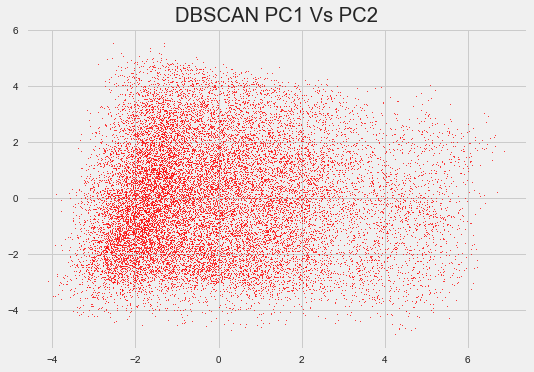

In [119]:
plt.style.use("fivethirtyeight")
plt.scatter(sample_pca[y_dbs ==0,0], sample_pca[y_dbs == 0,1], s=0.2, c='red')
plt.scatter(sample_pca[y_dbs ==1,0], sample_pca[y_dbs == 1,1], s=0.2, c='black')
plt.scatter(sample_pca[y_dbs ==2,0], sample_pca[y_dbs == 2,1], s=0.2, c='blue')
plt.title('DBSCAN PC1 Vs PC2')
plt.show()

Ens treu un únic cluster, mirem el silhouette:

In [120]:
dbscan_silhouette = metrics.silhouette_score(
   sample_pca, y_dbs
).round (2)
dbscan_silhouette

0.44

Busquem l'epsilon més adequat pel DBSCAN al punt de curvatura màxima

In [121]:
neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(sample_pca)
distances, indices = nbrs.kneighbors(sample_pca)

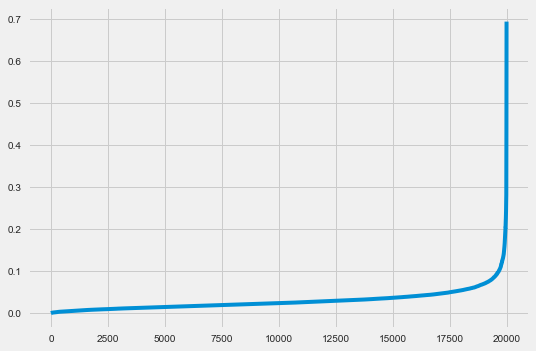

In [122]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Determinem l'epsilon a 0.08 com a punt de curvatura màxima

In [123]:
clustering = DBSCAN(eps = 0.08, min_samples = 4).fit(sample_pca)
y_dbs = clustering.labels_

In [124]:
y_dbs

array([ 0,  0, -1, ..., -1,  0,  0], dtype=int64)

In [125]:
from random import randint

# Agafem una llista de n colors:

color = []
n = 250
for i in range(n):
    color.append('#%06X' % randint(0, 0xFFFFFF))

In [126]:
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
vectorizer = np.vectorize(lambda x: color[x % len(color)])


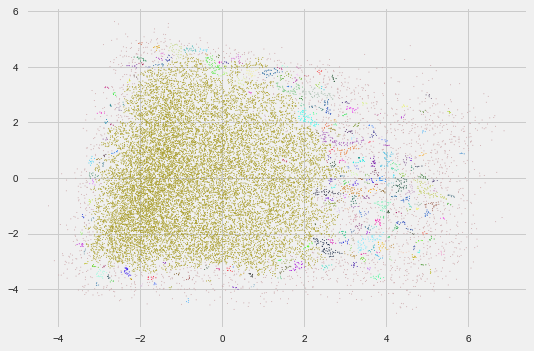

In [127]:
plt.scatter(sample_pca[:,0], sample_pca[:,1], c=vectorizer(y_dbs), s = 0.2)

In [128]:
slh_dbs = metrics.silhouette_score(
   sample_pca, y_dbs
).round (2)
slh_dbs

-0.51

Mirem els valors dels Labels resultants del DBSCAN:

In [129]:
y_dbs = pd.Series(y_dbs)

df_sample['Labels'] = y_dbs

El label = -1, és el noise, les dades que l'algoritme no ha agrupat a cap cluster.

In [130]:
df_sample['Labels'].value_counts()

 0      15836
-1       1837
 16        80
 90        60
 2         58
 18        53
 4         52
 17        51
 28        48
 33        44
 29        42
 27        41
 30        38
 23        33
 20        31
 22        31
 57        30
 59        29
 8         26
 41        23
 12        22
 25        21
 3         20
 70        19
 164       18
 98        17
 11        16
 14        16
 48        16
 46        14
 31        14
 125       14
 43        14
 37        14
 26        14
 54        13
 127       13
 101       13
 56        13
 39        13
 91        13
 117       12
 55        12
 100       11
 126       11
 156       11
 128       11
 153       11
 1         11
 66        11
 60        11
 75        11
 79        11
 174       11
 113       10
 47        10
 65        10
 138       10
 190       10
 180        9
 111        9
 49         9
 6          9
 93         9
 40         9
 76         9
 58         9
 148        9
 173        9
 35         9
 146        9
 129  

In [131]:
dbslen = len(df_sample['Labels'].unique())

In [132]:
print('El número de clusters resultants amb el DBSCAN és igual a:', dbslen)

El número de clusters resultants amb el DBSCAN és igual a: 255


### 2.2 GMM (Gaussian Mixture Models)

Provem de fer un model més amb Gaussian Mixture Models:

In [133]:
gmm = GaussianMixture(n_components=3)
gmm.fit(sample_pca)

GaussianMixture(n_components=3)

In [134]:
y_gmm = gmm.predict(sample_pca)

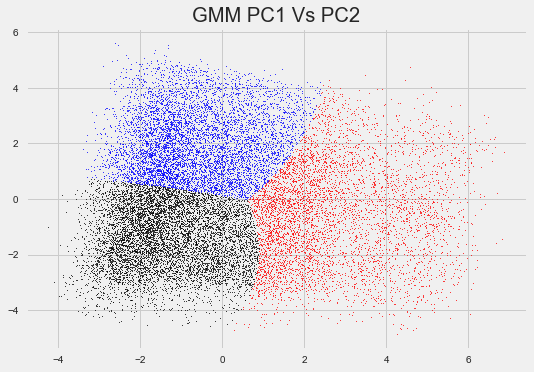

In [135]:
plt.scatter(sample_pca[y_gmm ==0,0], sample_pca[y_gmm == 0,1], s=0.2, c='red')
plt.scatter(sample_pca[y_gmm ==1,0], sample_pca[y_gmm == 1,1], s=0.2, c='black')
plt.scatter(sample_pca[y_gmm ==2,0], sample_pca[y_gmm == 2,1], s=0.2, c='blue')
plt.title('GMM PC1 Vs PC2')
plt.show()

In [136]:
slh_gmm = metrics.silhouette_score(sample_pca, y_gmm)
print ("gmm: silhouttte: ", slh_gmm)

gmm: silhouttte:  0.3943853499486114


## 3. K-Means Univariate: Arrival Delay

Mirem com s'aplica el K-Means al clusteritzar una sola variable, en aquest cas 'ArrDelay'

In [137]:
df_2.head()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1,3,4,2003.0,1955,2211.0,2225,17,335,128.0,150.0,116.0,-14.0,8.0,135,285,810,4.0,8.0,0,3,0,2.0,0.0,2.0,0.0,8.0
1,1,3,4,754.0,735,1002.0,1000,17,3231,128.0,145.0,113.0,2.0,19.0,135,285,810,5.0,10.0,0,3,0,2.0,0.0,2.0,0.0,8.0
2,1,3,4,628.0,620,804.0,750,17,448,96.0,90.0,76.0,14.0,8.0,140,48,515,3.0,17.0,0,3,0,2.0,0.0,2.0,0.0,8.0
3,1,3,4,1829.0,1755,1959.0,1925,17,3920,90.0,90.0,77.0,34.0,34.0,140,48,515,3.0,10.0,0,3,0,2.0,0.0,0.0,0.0,32.0
4,1,3,4,1940.0,1915,2121.0,2110,17,378,101.0,115.0,87.0,11.0,25.0,140,150,688,4.0,10.0,0,3,0,2.0,0.0,2.0,0.0,8.0


In [138]:
print(df_2['ArrDelay'].min(), df_2['ArrDelay'].max())

-60.0 83.0


In [139]:
X = df_2.iloc[:, [12]]

In [140]:
X

,ArrDelay
0,-14.0
1,2.0
2,14.0
3,34.0
4,11.0
...,...
1936750,-1.0
1936752,17.0
1936753,25.0
1936756,9.0


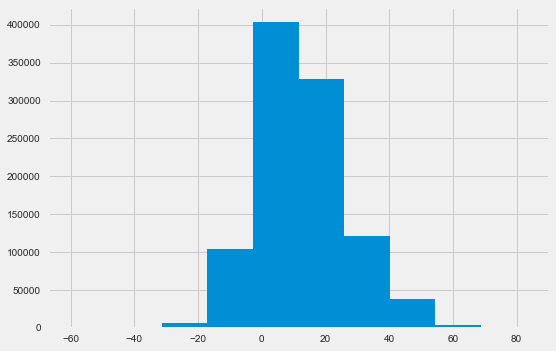

In [141]:
plt.hist(df_2['ArrDelay'])
plt.title('')
plt.show()

In [142]:
X = X.sample(20000, random_state = 0)

In [143]:
X = X.values

Elbow method..

In [144]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

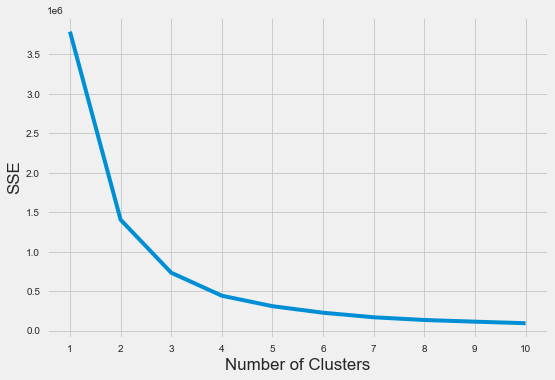

In [145]:
 plt.style.use("fivethirtyeight")
 plt.plot(range(1, 11), sse)
 plt.xticks(range(1, 11))
 plt.xlabel("Number of Clusters")
 plt.ylabel("SSE")
 plt.show()

In [146]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

3

Segons silhouette coefficient en comptes de SSE:

In [147]:
silhouette_coefficients = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    score = metrics.silhouette_score(X, kmeans.labels_, sample_size=4000)
    silhouette_coefficients.append(score)

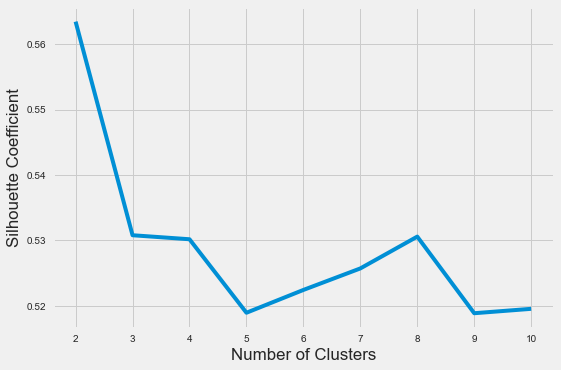

In [148]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [149]:
# Escollim 3 clusters:

kmeans = KMeans(init="random",
       n_clusters=3,
       n_init=10,
     max_iter=300,
               random_state = 0)

In [150]:
kmeans.fit(X)

KMeans(init='random', n_clusters=3, random_state=0)

In [151]:
kmeans.inertia_

737040.2076377077

In [152]:
kmeans.cluster_centers_

array([[16.05256968],
       [ 0.4494655 ],
       [35.66278714]])

In [153]:
kmeans.n_iter_

4

In [154]:
kmeans.labels_

array([2, 1, 0, ..., 1, 2, 0])

In [155]:
y_km = kmeans.labels_

In [156]:
y_km

array([2, 1, 0, ..., 1, 2, 0])

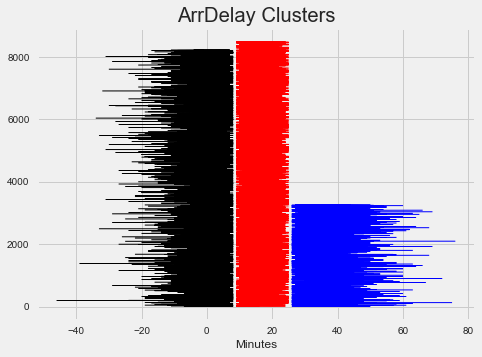

In [157]:
plt.figure(figsize=(7, 5))  
plt.plot(X[y_km ==0],range(len(X[y_km ==0])), c='red', linewidth=0.5)
plt.plot(X[y_km ==1],range(len(X[y_km ==1])),c='black', linewidth=0.5)
plt.plot(X[y_km ==2],range(len(X[y_km ==2])), c='blue', linewidth=0.5)
plt.title('ArrDelay Clusters')
plt.xlabel('Minutes', fontsize = 12)
plt.show()

L'algoritme ha dividit clarament l'enderreriment d'arrivada en tres Clusters: 
- {Cluster 0: menys de 7 minuts}  
- {Cluster 1: entre 7 i 25 minuts}  
- {Cluster 2: més de 25 minuts}

In [158]:
delay_slh = metrics.silhouette_score(X, y_km, metric = 'euclidean')
delay_slh

0.5339472495058398

In [159]:
metrics.calinski_harabasz_score(X, y_km)

41406.01049770848

## 4. K-Means amb totes les variables (sense PCA)

In [160]:
df_sample = df_2.sample(20000, random_state=1)

In [161]:
df_sample.reset_index(drop=True, inplace = True)

In [162]:
std_sample = StandardScaler().fit_transform(df_sample)

In [163]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(std_sample)
    sse.append(kmeans.inertia_)

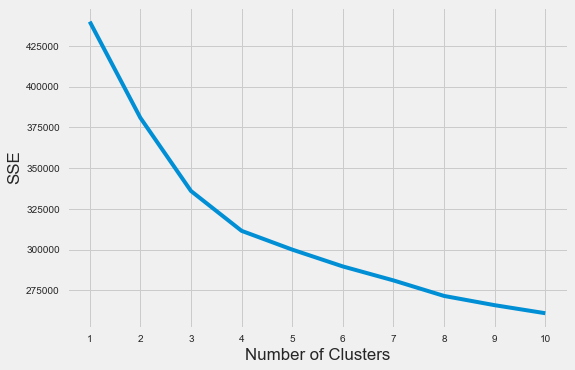

In [164]:
 plt.style.use("fivethirtyeight")
 plt.plot(range(1, 11), sse)
 plt.xticks(range(1, 11))
 plt.xlabel("Number of Clusters")
 plt.ylabel("SSE")
 plt.show()

In [165]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

4

Segons silhouette coefficient en comptes de SSE:

In [166]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(std_sample)
    score = metrics.silhouette_score(std_sample, kmeans.labels_, sample_size = 1000)
    silhouette_coefficients.append(score)

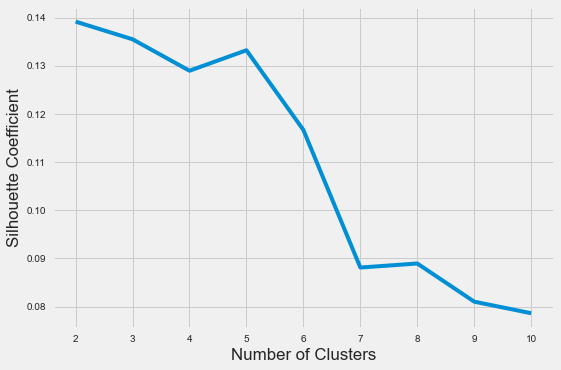

In [167]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

### Agrupació

In [168]:
# Volem 4 clusters

kmeans = KMeans(init="random",
       n_clusters=4,
       n_init=10,
     max_iter=300,
               random_state=0)

In [169]:
kmeans.fit(std_sample)

KMeans(init='random', n_clusters=4, random_state=0)

In [170]:
# The lowest SSE value
kmeans.inertia_

311502.07402280276

In [171]:
# Final locations of the centroid
kmeans.cluster_centers_

array([[-0.02447067,  0.00330437, -0.02256282,  0.50852962,  0.42454352,
         0.45958587,  0.37113577,  0.09513541, -0.00279249, -0.2790474 ,
        -0.28916139, -0.2793437 ,  1.64360583,  1.7824432 ,  0.07517781,
        -0.02376377, -0.29652885, -0.03106237, -0.04789319,  0.        ,
         0.        ,  0.        , -0.23171255,  0.        , -0.26522668,
         0.        ,  2.08339208],
       [-0.01558616, -0.02959824,  0.03657061,  0.81055234,  0.83021293,
         0.7276778 ,  0.74576843,  0.16749943,  0.11166632, -0.48400529,
        -0.46875201, -0.47992182, -0.24947402, -0.27635534, -0.07294415,
        -0.02895816, -0.46522631, -0.12488206, -0.09015962,  0.        ,
         0.        ,  0.        ,  0.00971656,  0.        , -0.02844563,
         0.        , -0.32704541],
       [ 0.01040254,  0.00444071, -0.00860432, -0.0907518 , -0.08161436,
         0.16536244,  0.1832357 , -0.44683   , -0.48375284,  1.44793869,
         1.44616349,  1.44974143, -0.31269445, -0.1790

In [172]:
# The number of iterations required to converge
kmeans.n_iter_

11

In [173]:
labels = kmeans.labels_

In [174]:
labels

array([3, 2, 0, ..., 2, 1, 3])

Visualitzem els dues variables (ArrDelay i DepDelay) i la distribució dels clusters i els seus centres:

In [175]:
centroids = kmeans.cluster_centers_

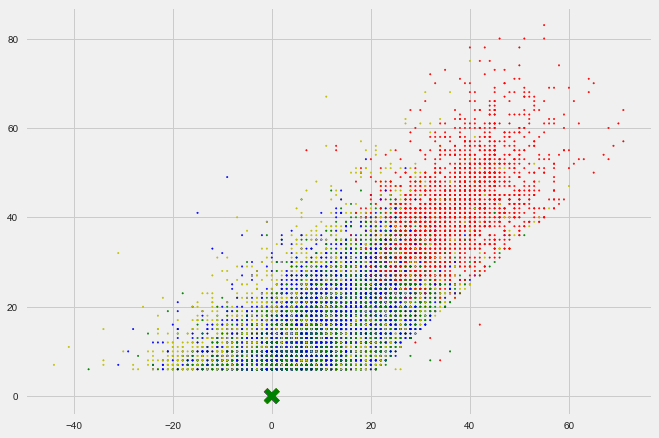

In [176]:
colors = ['r','b','y','g','c','m']
plt.figure(figsize=(10, 7))  
plt.scatter(df_sample['ArrDelay'], df_sample['DepDelay'], color=[colors[l_] for l_ in labels], label=labels, s=2) 
plt.scatter(centroids[:, 0],centroids[:, 1], color=[c for c in colors[:len(centroids)]], marker = "x", s=150, linewidths = 5, zorder = 10)

In [177]:
slh_kmeans = metrics.silhouette_score(std_sample, labels, metric = 'euclidean', sample_size = 4000)
slh_kmeans

0.13008189741506304

### Nivell 2


#### - Exercici 2
Classifica els diferents vols utilitzant l'algorisme de clustering jeràrquic.

Hi ha dos tipus d'algorismes de clsutering jeràrquic o de connectivitat: aglomeratius i divisiu. El primer comença per un punt individual i en va sumant, d'abaix a dalt. El segon comença amb totes les dades juntes i les va dividint, de dalt a baix.  

El problema dels algorismes de clustering es saber on aturar-nos en l'algomeració o divisió. Per això ens servim dels dendograms, observem quin és l'espai vertical més gran de l'arbre de connexions i decidim per el número de clusters que es troba en aquest espai.

## 5. Clustering jeràrquic amb mostra de totes les variables (sense PCA)

In [178]:
# Agafem una mostra i resetegem l'index per poder ajuntar amb els labels després de clusteritzar:
df_sample = df_1.sample(20000, random_state = 1)
df_sample.reset_index(drop=True, inplace = True)

In [179]:
z = sch.linkage(df_sample, method='ward')

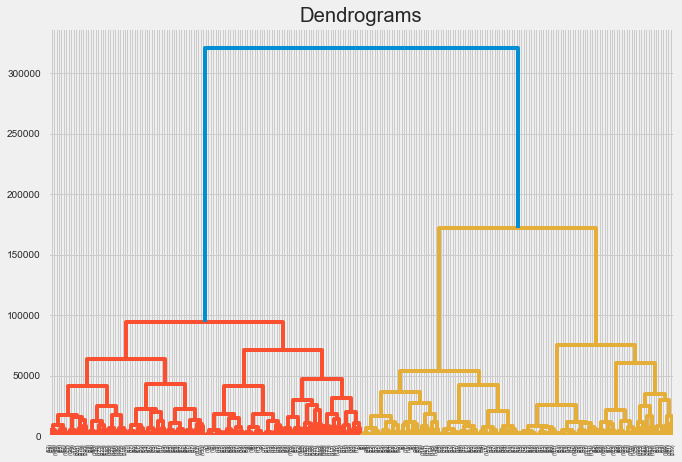

In [180]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dendrogram = sch.dendrogram(z, p=7, truncate_mode = 'level')

In [181]:
# Agafem 2 clusters ja que clarament l'espai vertical més gran del dendogram entre vifurcacions és el de 2:

agg = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
agg.fit(df_sample)
y_agg = agg.labels_

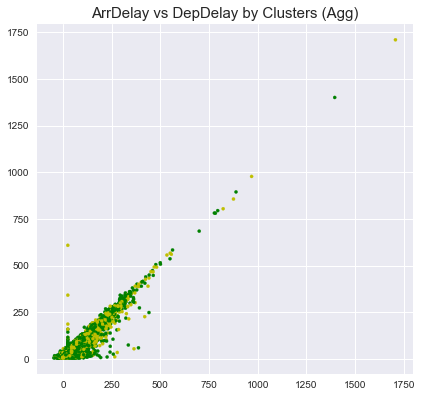

In [182]:
plt.style.use('seaborn')
LABEL_COLOR_MAP = {0 : 'y',
                   1 : 'g',
                   }

label_color = [LABEL_COLOR_MAP[l] for l in y_agg]

plt.figure(figsize=(6, 6))  
plt.scatter(df_sample['ArrDelay'], df_sample['DepDelay'], c=label_color, s = 10) 
plt.title('ArrDelay vs DepDelay by Clusters (Agg)', fontsize=15)
plt.show()

In [183]:
slh_agg1 = metrics.silhouette_score(df_sample, y_agg, metric = 'euclidean')
slh_agg1

0.42388646414773823

### Estudi estadístic dels clusters jeràrquic (agg.) en el df original

In [184]:
y_agg = pd.Series(y_agg)

df_sample['Labels'] = y_agg

El label = -1, és el noise, les dades que l'algoritme no ha agrupat a cap cluster.

In [185]:
df_sample['Labels'].value_counts()

1    11638
0     8362
Name: Labels, dtype: int64

In [186]:
len(df_sample['Labels'].unique())

2

#### Número d'observacions assignades a cada cluster:

- Cluster 0:    11638
- Cluster 1:    8362

In [187]:
label_grp = df_sample.groupby(['Labels'])

In [188]:
categoriques = ['UniqueCarrier', 'Origin', 'Dest', 'CancellationCode']

Eliminem, a banda de les categòriques, les columnes numèriques que no ens serveixen per l'anàlisis estadístic:

In [189]:
numeriques = df_sample.drop(['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest', 'CancellationCode',
                             'Labels', 'SecurityDelay', 'WeatherDelay', 'Diverted', 'Cancelled'],1).columns

### 5.1 Estudi estadístic dels clusters per variables numèriques i categòriques:

#### Categòriques: Unique Carrier

Estudiem com queden dividits els vols de les companyies en la divisió per clusters amb K-Means i PCA:

In [190]:
def get_integer_mapping(le):
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res

integerMapping = get_integer_mapping(uq_encoder)

In [191]:
len(df['UniqueCarrier'].unique())

20

In [192]:
for i in range (0,2):
    x = len(label_grp.get_group(i)['UniqueCarrier'].unique())
    print(x)

16
18


Cap dels dos clusters té valors de les 20 companyies. Mirem els valors concrets:

In [193]:
for i in range (0,2):
    x = label_grp.get_group(i)['UniqueCarrier'].value_counts()
    print(x)

17    1580
11    1450
14    1368
7      832
18     799
19     617
13     551
0      507
1      309
16     107
6       99
5       51
12      50
15      32
9        5
4        5
Name: UniqueCarrier, dtype: int64
17    2353
1     1636
15    1441
6     1089
5     1041
16     944
12     753
9      700
4      536
3      420
8      302
18     229
10      89
19      58
0       37
2        5
14       4
11       1
Name: UniqueCarrier, dtype: int64


Cluster 0: falta 2,3,8,10  
Cluster 1: falta 7 i 13

Afegim les companyies de les quals no en tenim cap observació pel Cluster 0 i 1, per poder mapejar-les a la visualització:

In [194]:
falta = pd.Series([0, 0, 0, 0], index=[2,3, 8, 10])
x = label_grp.get_group(0)['UniqueCarrier'].value_counts()
x = x.append(falta)

In [195]:
falta = pd.Series([0, 0], index=[7, 13])
y = label_grp.get_group(1)['UniqueCarrier'].value_counts()
y = y.append(falta)

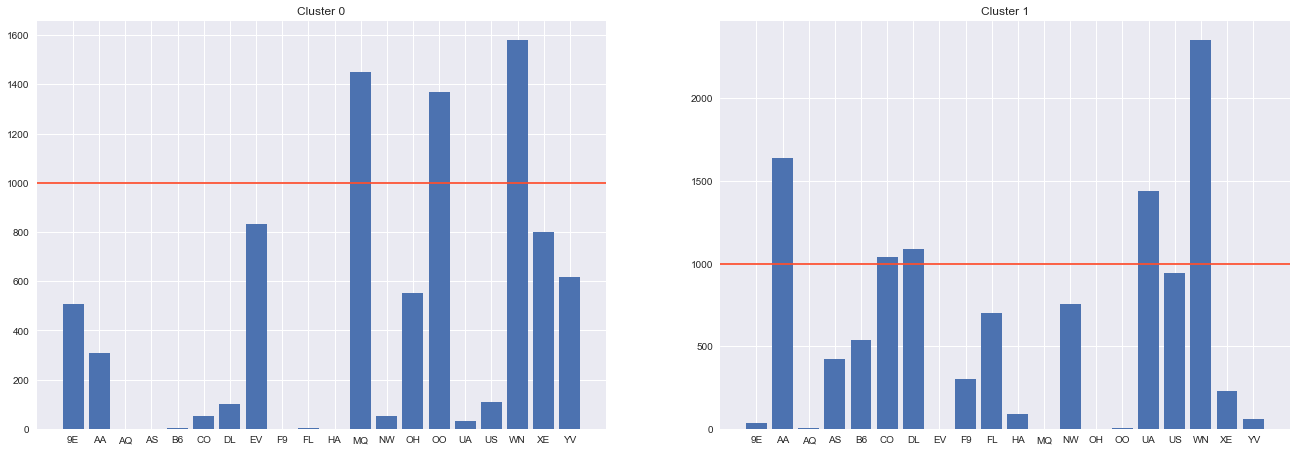

In [196]:
plt.style.use('seaborn')

fig, axes = plt.subplots(1,2, figsize=(20, 7))

index = integerMapping.keys()
values = x.sort_index()
axes[0].bar(index, values)
axes[0].set_xticks(range(0, 20))
axes[0].set_title('Cluster 0')
axes[0].axhline(1000, color ='#fc4f30', label='Avg. Number of Flights by Carrier')

index = integerMapping.keys()
values = y.sort_index()
axes[1].bar(index, values)
axes[1].set_xticks(range(0, 20))
axes[1].set_title('Cluster 1')
axes[1].axhline(1000, color ='#fc4f30', label='Avg. Number of Flights by Carrier')


plt.show()

Conclusions: observem que els dos clusers són força diferents proporcionalment en la l'assignació de carriers. En el Cluster 0 Tenim tots els vols del Carrier 'MQ', 'OH', i 'EV' i gairabé tots els de '9E','OO', 'XE' i 'YV' . Per altra banda tenim moltes menys observacions del Carrier 'AA', 'CO', 'DL', 'NW', 'UA'i 'US. El cluster 1 conté totes, o gairebé totes, les observacions dels carriers 'AS', 'B6', 'F9', 'FL', 'HA'.  
Hi ha una diferència clara de clusters en quant a la divisió dels vols per Carriers. Estan gairebé partits per carriers menys en el cas de 'WN' i una mica menys, 'AA'.

#### Categòriques: Origen i Destí

Igual que en el primer estudi de clusters, hem decidit agafar només aquells aeroports que suposin, com a mínim, un 2% del tràfic aeri total de la mostra. Primer agafem els del df original i després els de la mostra començant pels d'origen:

Recuperem els valors categòrics del LabelEncoder dels aeroports amb un mapping:

In [197]:
def get_integer_mapping(le):
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res

integerMapping = get_integer_mapping(org_encoder)

Invertim els valors del diccionari perquè els keys siguin els valors numèrics i els values els categòrics:

In [198]:
inv_map = {v: k for k, v in integerMapping.items()}

In [199]:
df['Origin'].value_counts()[df['Origin'].value_counts(normalize =True, ascending=False) > 0.02]

18     131613
210    125979
81      95414
80      74323
157     58772
136     56847
220     55720
155     53710
96      52925
87      43923
259     43801
Name: Origin, dtype: int64

In [200]:
x = df_sample['Origin'].value_counts(normalize =True, ascending=False)

In [201]:
x = x[x > 0.02]
print(x)

210    0.06530
18     0.06465
81     0.04745
80     0.03885
157    0.03215
136    0.03090
220    0.03015
155    0.02660
96     0.02620
87     0.02360
259    0.02245
Name: Origin, dtype: float64


In [202]:
org_values =  pd.DataFrame(data = x.index)
org_values[0] = org_values[0].map(inv_map)
org_values['values'] = x.values
org_values.columns = ['Origin', ' Flights']
org_values

,Origin,Flights
0,ORD,0.06530
1,ATL,0.06465
2,DFW,0.04745
3,DEN,0.03885
4,LAX,0.03215
5,IAH,0.03090
6,PHX,0.03015
7,LAS,0.02660
8,EWR,0.02620
9,DTW,0.02360


Passem els labelencoders dels aeroports d'origen majoritaris a un DataFrame i amb el map invertit en recuprem els valors categòrics:

In [203]:
for i in range (0,2):
    x = label_grp.get_group(i)['Origin'].value_counts(normalize =True, ascending=False)
    y = label_grp.get_group(i)['Origin'].value_counts(ascending=False)[x > 0.02]
    org_values =  pd.DataFrame(data = y.index)
    org_values[0] = org_values[0].map(inv_map)
    org_values['values'] = y.values
    org_values.columns = ['Origin', ' Flights']
    print(org_values)
   
    

   Origin   Flights
0     ORD       637
1     ATL       529
2     DFW       424
3     IAH       237
4     LAX       227
5     CVG       219
6     DEN       210
7     DTW       202
8     SLC       193
9     EWR       186
10    PHX       184
   Origin   Flights
0     ATL       764
1     ORD       669
2     DEN       567
3     DFW       525
4     PHX       419
5     LAX       416
6     LAS       408
7     IAH       381
8     EWR       338
9     SFO       296
10    MCO       292
11    SEA       274
12    DTW       270
13    JFK       268
14    MSP       267


Conclusions: en el cas dels aeroports d'origen veiem que es repeteixen ATL (Atlanta), ORD (Chicago O'Hare) en les dues primeres posicions en els dos clusters. El Cluster 1 té més valors categòrics i PHX (Phoenix) en quarta posició a diferència de la desena en el Cluster 0. Observem que CVG (Cincinnati), DTW (Detroit), SLC (Salt Lake City) només hi són presents en el Cluster 0.
Observem que LAS (Las Vegas), MCO (Orlando), SEA (Seattle-Tacoma), JFK (New York) i MSP (Minneapolis) només hi són presents en el Cluster 1.  

Tot i així hem de tenir en compte que nosaltres hem marcat un threshold del 2% del tràfic d'origens de la mostra per tal de facilitar l'anàlisis. Quan diem que no apareixen, vol dir que no estan presents en aquest threshold, el més probable és que de tots aquests aeroports n'hi hagi mostres als dos clusters.

Fem el mateix amb els de destí:

In [204]:
def get_integer_mapping(le):
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res

integerMapping = get_integer_mapping(dest_encoder)

In [205]:
inv_map = {v: k for k, v in integerMapping.items()}

In [206]:
df['Dest'].value_counts()[df['Dest'].value_counts(normalize =True, ascending=False) > 0.02]

ORD    108984
ATL    106898
DFW     70657
DEN     63003
LAX     59969
EWR     55861
LAS     48858
PHX     47836
SFO     46876
IAH     43905
Name: Dest, dtype: int64

In [207]:
x = df_sample['Dest'].value_counts(normalize =True, ascending=False)

x = x[x > 0.02]
x

211    0.05805
18     0.05765
82     0.03790
81     0.03230
158    0.03040
97     0.02865
156    0.02710
221    0.02525
259    0.02395
137    0.02185
Name: Dest, dtype: float64

In [208]:
dest_values =  pd.DataFrame(data = x.index)
dest_values[0] = dest_values[0].map(inv_map)
dest_values['values'] = x.values
dest_values.columns = ['Dest', ' Flights']
dest_values

,Dest,Flights
0,ORD,0.05805
1,ATL,0.05765
2,DFW,0.03790
3,DEN,0.03230
4,LAX,0.03040
5,EWR,0.02865
6,LAS,0.02710
7,PHX,0.02525
8,SFO,0.02395
9,IAH,0.02185


In [209]:
for i in range (0,2):
    x = label_grp.get_group(i)['Dest'].value_counts(normalize =True, ascending=False)
    y = label_grp.get_group(i)['Dest'].value_counts(ascending=False)[x > 0.02]
    dest_values =  pd.DataFrame(data = y.index)
    dest_values[0] = dest_values[0].map(inv_map)
    dest_values['values'] = y.values
    dest_values.columns = ['Dest', ' Flights']
    print(dest_values)

   

  Dest   Flights
0  ORD       603
1  ATL       483
2  DFW       327
3  LAX       229
4  DEN       176
5  EWR       175
6  CVG       173
7  DTW       169
   Dest   Flights
0   ATL       670
1   ORD       558
2   DEN       470
3   DFW       431
4   EWR       398
5   LAX       379
6   LAS       378
7   PHX       346
8   SFO       314
9   MCO       307
10  SEA       306
11  IAH       277
12  JFK       273
13  LGA       253
14  PHL       248


Conclusions: Veiem com ATL (Atlanta) i ORD (Orlando) segueixen en les primeres posicions tant en el Cluster 0 com en el Cluster 1. El Cluster 1 té gairebé el doble d'atributs categòrics (15 vs 8 del Cluster 0). Tot i això el Cluster 0 conté dos aeroports que no trobem en el Cluster 1 : CVG (Cincinnati) i DTW (Detroit). El Cluster 1, des del 7è aeroport (LAS) fins al 15è (PHL) només hi són en el primer.

Com hem comentat que no hi siguin aquí vol dir que tenen un tràfic inferior al 2% de les destinacions totals de la mostra, no que no hi siguin presents a la mostra.

#### Numèriques

In [210]:
numeriques

Index(['DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'FlightNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'CarrierDelay', 'NASDelay', 'LateAircraftDelay'], dtype='object')

Fem una taula amb les mitjanes i desviacions típiques de cada variable numèrica segons el seu cluster:

In [211]:
cl0_mean = label_grp[numeriques].get_group(0).mean()
cl0_std = label_grp[numeriques].get_group(0).std()

In [212]:
cl1_mean = label_grp[numeriques].get_group(1).mean()
cl1_std = label_grp[numeriques].get_group(1).std()

In [213]:
df_numeric = pd.DataFrame()

In [214]:
df_numeric['Variables'] = cl0_mean.index

In [215]:
df_numeric['Mean 0'] =cl0_mean.values
df_numeric['Mean 1'] =cl1_mean.values

In [216]:
df_numeric['Std 0'] =cl0_std.values
df_numeric['Std 1'] =cl1_std.values

In [217]:
df_numeric

,Variables,Mean 0,Mean 1,Std 0,Std 1
0,DepTime,1551.394044,1487.426706,429.434209,463.025698
1,CRSDepTime,1482.297178,1455.079223,416.020492,426.202358
2,ArrTime,1660.496412,1578.156986,489.963058,575.646072
3,CRSArrTime,1651.481703,1624.286647,420.817199,485.454573
4,FlightNum,4057.870605,833.465028,1587.701896,587.433590
5,ActualElapsedTime,104.000120,155.169015,43.801524,80.881489
6,CRSElapsedTime,104.541617,156.953686,42.252427,80.409944
7,AirTime,79.555609,129.974566,40.736610,77.044271
8,ArrDelay,43.878976,40.113164,58.448371,56.929661
9,DepDelay,44.552499,41.678983,55.592566,53.874439


Conclusions: en el cas de les variables numèriques, només observem diferències significatives entre Clusters en el cas de la distància, sent gairebé el doble la mitjana del Cluster 1 (516 vs 956 milles), i per tant també en 'AirTime', 'CRSElapsedTime' i 'ActualElapsedTime'. La resta de variables o bé no són significatives o no hi ha cap canvi notable.

## 6. Clustering jeràrquic amb PCA

Recuperem el PCA amb 2 PC per poder visualitzar els resultats del cluster jeràrquic i n'agafem una mostra:

In [218]:
df_sample = df_pca.sample(20000)
df_sample.reset_index(drop=True, inplace = True)

In [219]:
z = sch.linkage(df_sample, method='ward')

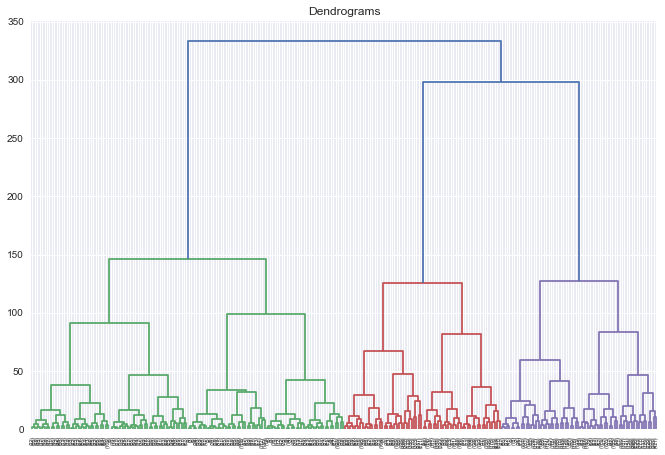

In [220]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dendrogram = sch.dendrogram(z, p=7, truncate_mode='level')
plt.show()

In [221]:
# Agafem 3 clusters ja que clarament l'espai vertical més gran del dendogram entre vifurcacions és el de 2:

agg = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
agg.fit(df_sample)
y_agg = agg.labels_

In [222]:
df_sample

,PC 1,PC 2
0,-0.048999,-1.086180
1,-0.711220,0.908306
2,-0.439797,-0.040445
3,2.759485,-0.551382
4,-1.242029,-0.298526
...,...,...
19995,-2.257996,1.874214
19996,-1.681917,2.408946
19997,-2.656732,1.336974
19998,-0.857344,-1.292256


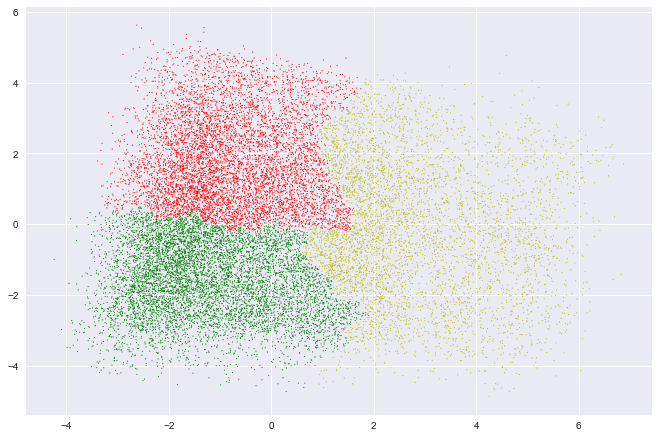

In [223]:
plt.style.use('seaborn')
LABEL_COLOR_MAP = {0 : 'y',
                   1 : 'g',
                   2: 'r'
                   }

label_color = [LABEL_COLOR_MAP[l] for l in y_agg]
plt.figure(figsize=(10, 7))  
plt.scatter(df_sample['PC 1'], df_sample['PC 2'], c=label_color, s=0.5) 
plt.show()

In [224]:
slh_aggpc = metrics.silhouette_score(df_sample, y_agg, metric = 'euclidean')
slh_aggpc

0.3759317866909262

### Nivell 3


#### - Exercici 3
Calcula el rendiment del clustering mitjançant un paràmetre com pot ser silhouette.

- Hem anat realitzant silhouette per evaluar el rendiment dels algorismes de cluster cada cop que hem presentat un model. També hem fet ús de Sum of Squares Error (SSE) per calcular el nombre de clusters pel K-means i l'explained variance ratio pel nombre de principal components al PCA. En el cas de DBSCAN ens hem servit de l'algoritme K-Nearest Neighbors per escollir el paràmetre epsilon més adhient. Puntualment també hem fet ús d'adjusted rand score.

In [225]:
metrics_slh = slh_13pc, slh_2pc, slh_dbs, slh_gmm, delay_slh, slh_kmeans, slh_agg1, slh_aggpc

In [226]:
models = 'K-M 13PC', 'K-M 2PC', 'DBSCAN 2PC', 'GMM 2PC', 'K-M Univ.', 'K-M DF' , 'AGG DF', 'AGG 2PC'

In [227]:
df_metrics  = pd.DataFrame(data = models
             , columns = ['Model'])
df_metrics

,Model
0,K-M 13PC
1,K-M 2PC
2,DBSCAN 2PC
3,GMM 2PC
4,K-M Univ.
5,K-M DF
6,AGG DF
7,AGG 2PC


In [228]:
metrics_slh = pd.Series(metrics_slh)

In [229]:
df_metrics['Silhouette scr.'] = metrics_slh

In [230]:
df_metrics

,Model,Silhouette scr.
0,K-M 13PC,0.138095
1,K-M 2PC,0.394721
2,DBSCAN 2PC,-0.510000
3,GMM 2PC,0.394385
4,K-M Univ.,0.533947
5,K-M DF,0.130082
6,AGG DF,0.423886
7,AGG 2PC,0.375932


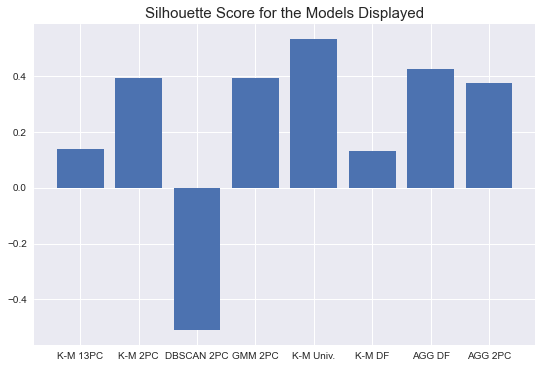

In [231]:
plt.style.use('seaborn')
plt.bar(df_metrics['Model'], df_metrics['Silhouette scr.'])
plt.xticks(fontsize=10)
plt.title('Silhouette Score for the Models Displayed', fontsize=15)
plt.show()

In [232]:
# DEBUG del notebook:

# import nbformat as nbf
# from glob import glob

# import uuid
# def get_cell_id(id_length=8):
#     return uuid.uuid4().hex[:id_length]

# # your notebook name/keyword
# nb_name = 'Sprint 15. Aprenentatge No Supervisat - Agrupació 2'
# notebooks = list(filter(lambda x: nb_name in x, glob("./*.ipynb", recursive=True)))

# # iterate over notebooks
# for ipath in sorted(notebooks):
#     # load notebook
#     ntbk = nbf.read(ipath, nbf.NO_CONVERT)
    
#     cell_ids = []
#     for cell in ntbk.cells:
#         cell_ids.append(cell['id'])

#     # reset cell ids if there are duplicates
#     if not len(cell_ids) == len(set(cell_ids)): 
#         for cell in ntbk.cells:
#             cell['id'] = get_cell_id()

#     nbf.write(ntbk, ipath)